In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(useful)) 

In [2]:
library('biomaRt')

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [3]:
data <- read.csv("bulk/iGABA_pre_merged_symbols.tsv",sep="\t",header=T,row.names=1,quote="")
corner(data) 

,iGABA_pre_22,iGABA_pre_1,iGABA_pre_23,iGABA_pre_21,iGABA_pre_93
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,5,0,0
5_8S_rRNA,0,0,0,0,0
7SK,1,1,0,0,0
A1BG,0,0,1,0,0
A1BG-AS1,0,0,0,1,0


In [28]:
meta <- read.csv("bulk/prepat_sample_meta.tsv",sep="\t",header=T,row.names=1,quote="")
row.names(meta) <- paste0("iGABA_pre_",row.names(meta))

              counts
iGABA_pre_24  421492
iGABA_pre_23  920916
iGABA_pre_74 1045205
iGABA_pre_66 1048094
iGABA_pre_30 1122436
iGABA_pre_33 1159890
iGABA_pre_68 1233039
iGABA_pre_20 1339230
iGABA_pre_67 1598170
iGABA_pre_13 1687442
iGABA_pre_14 1703098
iGABA_pre_9  1787247
iGABA_pre_31 1819429
iGABA_pre_37 1831551
iGABA_pre_45 1836588
iGABA_pre_65 1846057
iGABA_pre_12 1943566
iGABA_pre_15 1945009
iGABA_pre_16 2025133
iGABA_pre_58 2028077


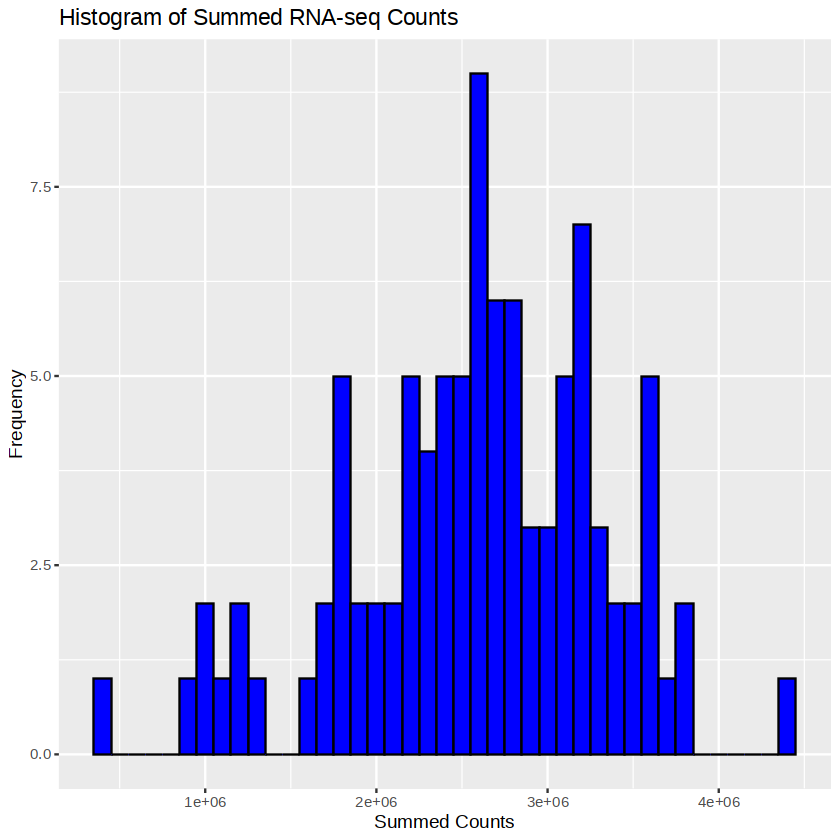

In [30]:


# Load necessary libraries
library(ggplot2)
library(dplyr)

# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

# Plot a histogram of the counts
ggplot(counts_df, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency')

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)


In [31]:
# Define the minimum count threshold
min_count_threshold <- 1500000  # Replace with your desired threshold

# Filter out samples (columns) with fewer than the minimum threshold counts
filtered_data <- data[, colSums(data) >= min_count_threshold]
filtered_meta <- meta[colSums(data) >= min_count_threshold,]


In [36]:
dim(filtered_meta)

[1] 88 15

In [37]:
dim(filtered_data)

[1] 61578    88

In [48]:
deseq2.colData <- data.frame(row.names=colnames(filtered_data))
#deseq2.colData$pattern <- 'pre'


deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

In [49]:
corner(deseq2.colData)

,Sample,AP_axis,DV_axis,Basal_media,M_XAV
,<int>,<chr>,<chr>,<chr>,<dbl>
iGABA_pre_0,1,XAV_3,BMP4_3,NIM,5.0
iGABA_pre_1,2,XAV_3_FGF8,BMP4_3,NIM,5.0
iGABA_pre_3,4,ctrl,BMP4_3,NIM,0.0
iGABA_pre_4,5,XAV_3,BMP4_1,NIM,5.0
iGABA_pre_6,7,XAV_1,BMP4_1,NIM,0.2


In [50]:
#colData$group <- factor(colData$group)

columns_to_factor <- c("M_NIM","M_N2B27_2Si","M_N2B27_SB_CHIR","Basal_media")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(columns_to_factor), factor)

numeric_columns_to_scale <- c("M_XAV","M_CHIR","M_RA","M_FGF8","M_BMP4","M_SHH")
# Scale the specified numeric columns
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(numeric_columns_to_scale), scale)



In [54]:
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)
dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA+M_XAV+M_CHIR+M_FGF8+M_BMP4+M_SHH+Basal_media)

#dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA)

In [55]:
colnames(deseq2.colData)

[1] "Sample"          "AP_axis"         "DV_axis"         "Basal_media"    
 [5] "M_XAV"           "M_CHIR"          "M_RA"            "M_FGF8"         
 [9] "M_BMP4"          "M_SHH"           "M_PM"            "M_CycA"         
[13] "M_NIM"           "M_N2B27_2Si"     "M_N2B27_SB_CHIR" "sums"

In [56]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run Analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(rownames(res)), ]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [57]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [58]:
vsd <- vst(dds, blind=FALSE)
#rld <- rlog(dds, blind=FALSE) 

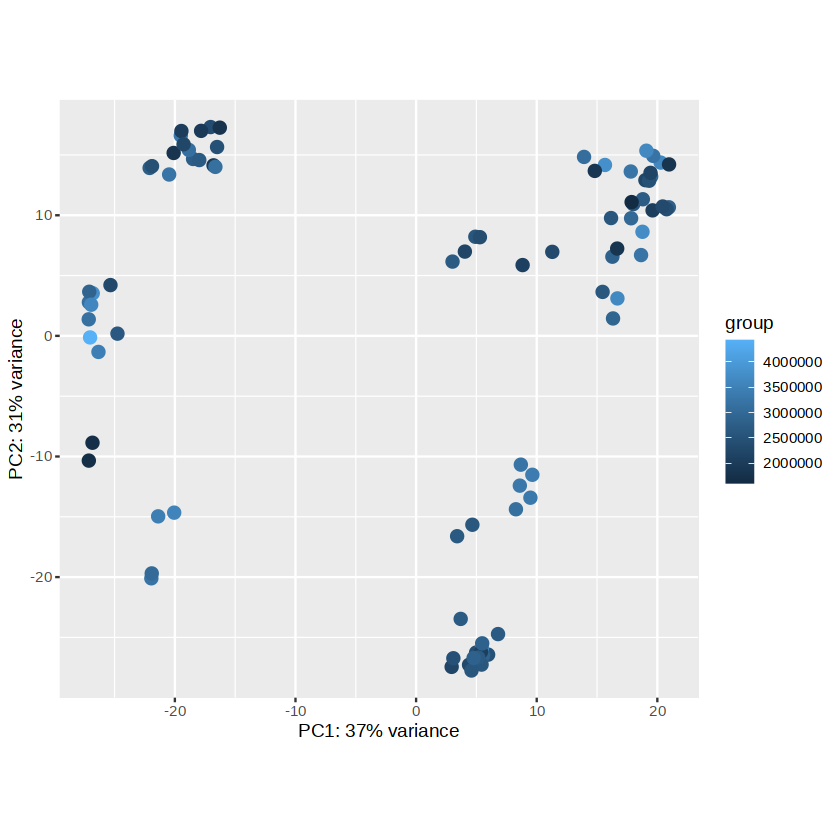

In [59]:
pca_df <- vsd
ntop <- 1000
plotPCA(object = pca_df,intgroup=c('sums'))

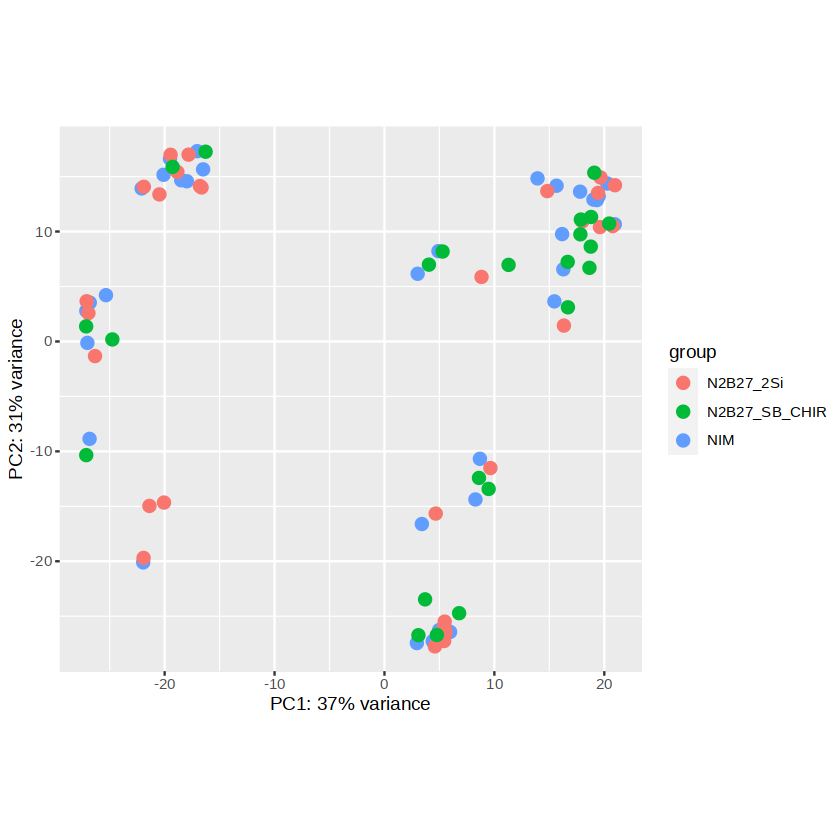

In [68]:
plotPCA(object = pca_df,intgroup=c('Basal_media'))

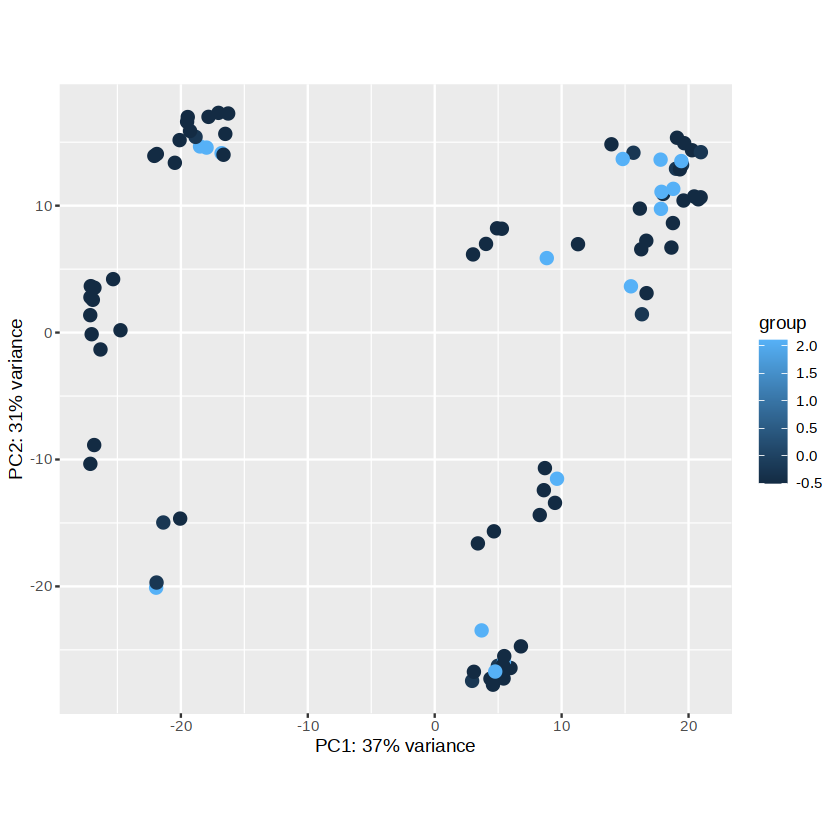

In [63]:
plotPCA(object = pca_df,intgroup=c('M_BMP4'))

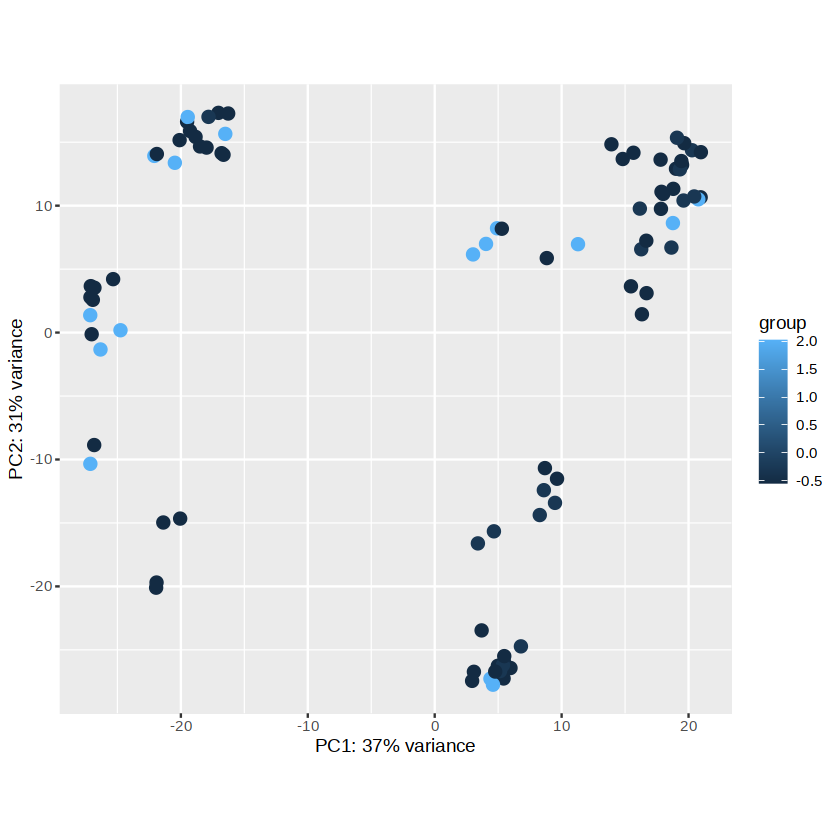

In [62]:
plotPCA(object = pca_df,intgroup=c('M_SHH'))

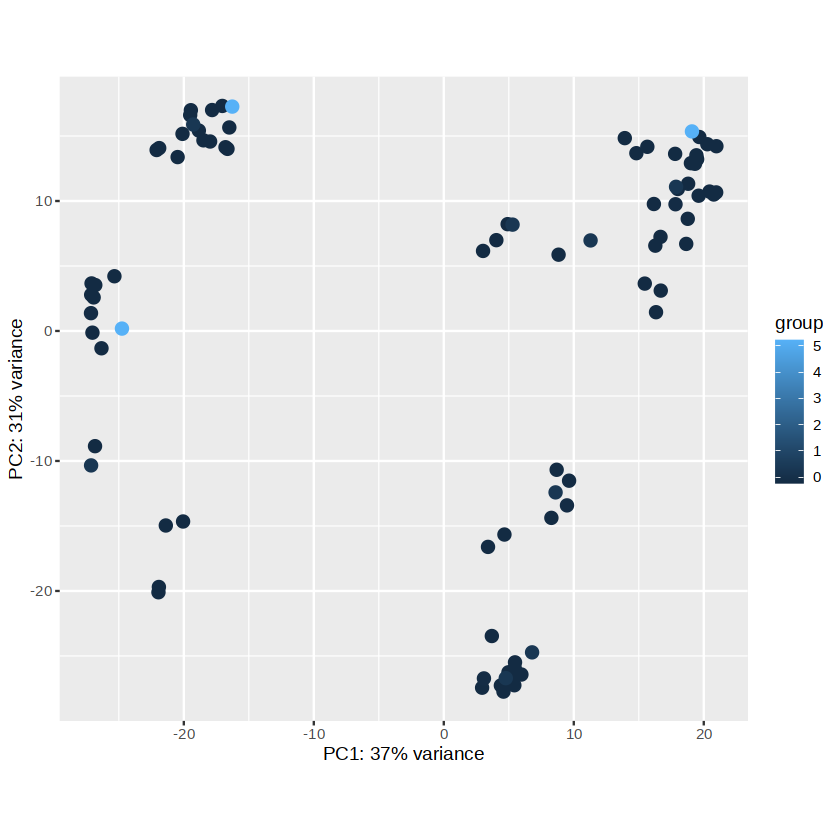

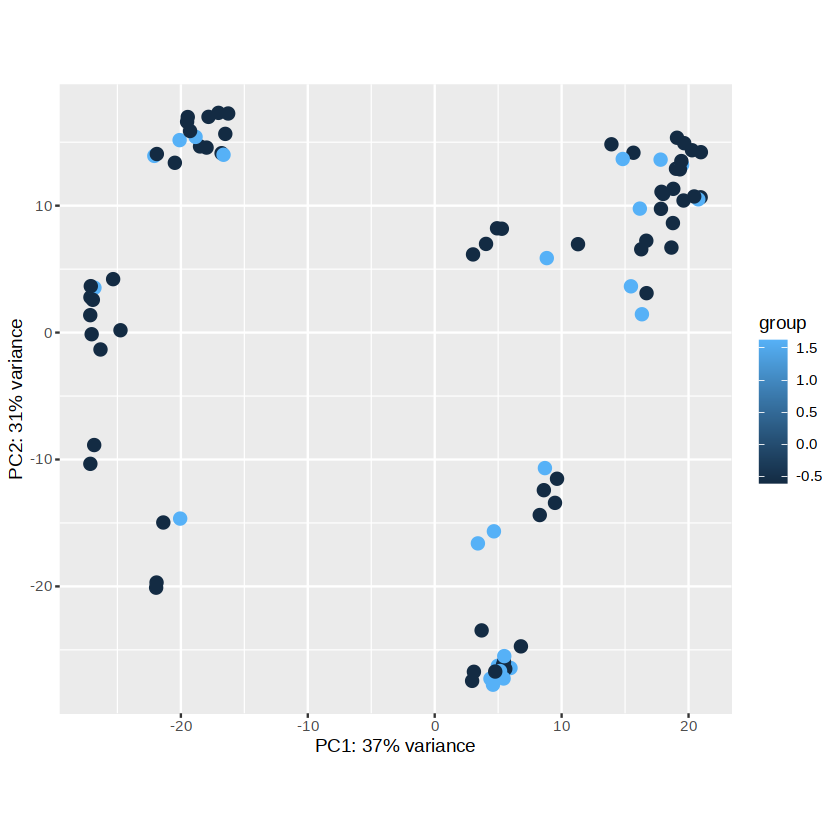

In [71]:
plotPCA(object = pca_df,intgroup=c('M_RA'))
plotPCA(object = pca_df,intgroup=c('M_CHIR'))

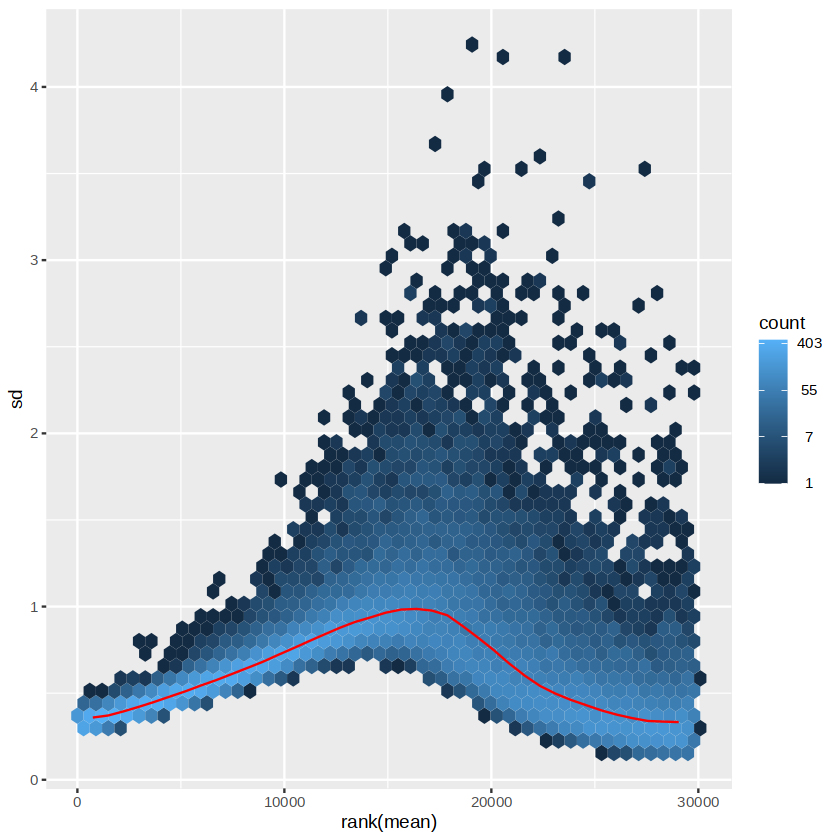

In [72]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd)) 

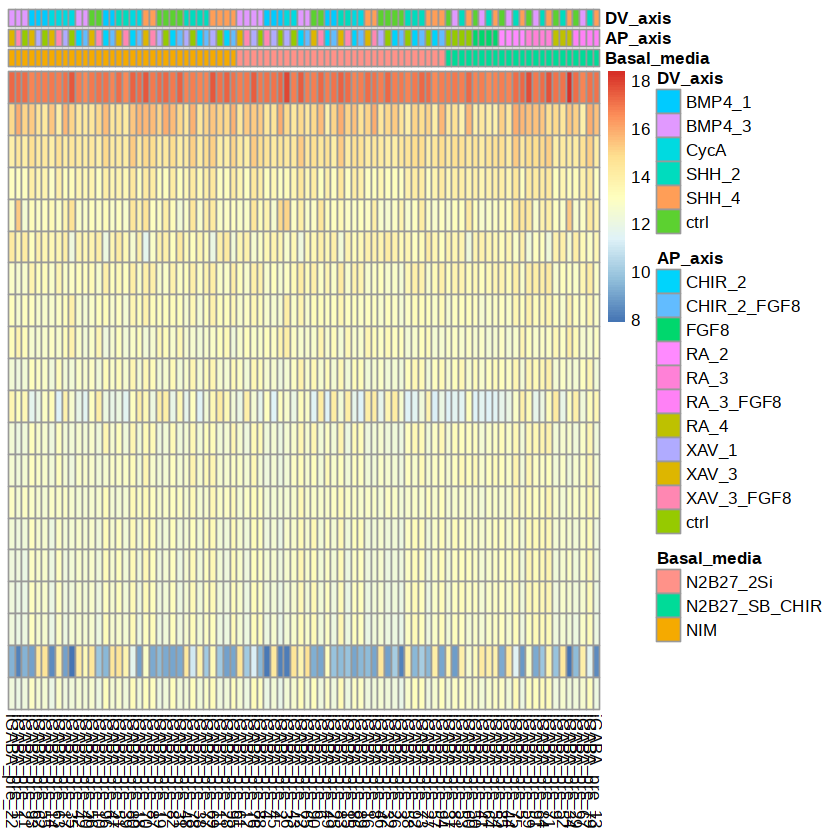

In [79]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("Basal_media","AP_axis","DV_axis")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

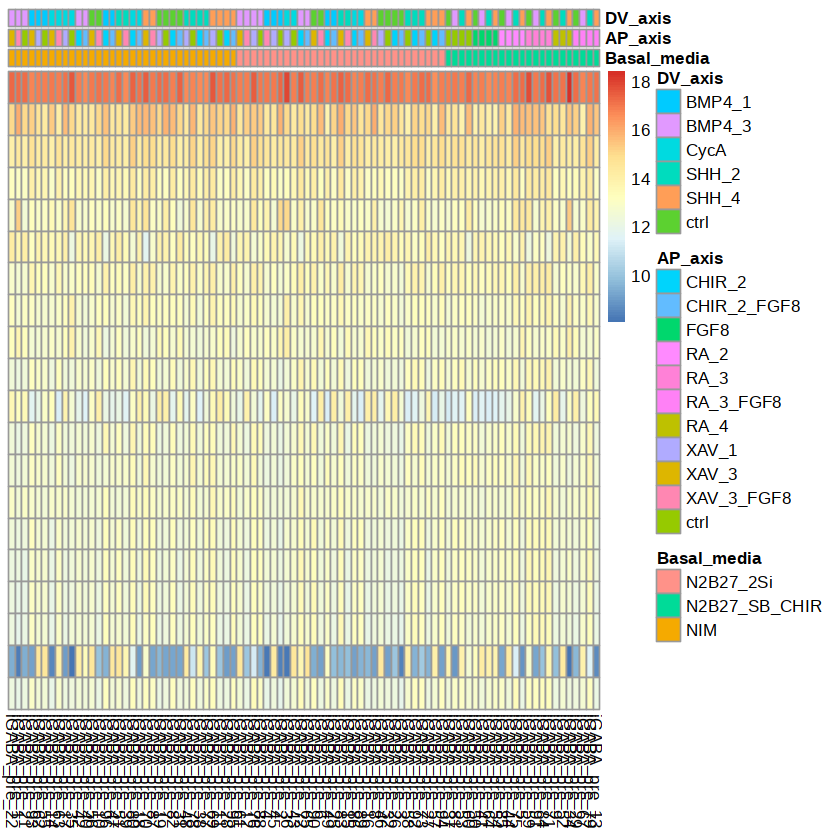

In [77]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("Basal_media","AP_axis","DV_axis")])
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

In [87]:
library(limma)


Attaching package: 'limma'


The following object is masked from 'package:DESeq2':

    plotMA


The following object is masked from 'package:BiocGenerics':

    plotMA




In [90]:
vsd_l <- vsd

In [92]:
assay(vsd_l) <- limma::removeBatchEffect(assay(vsd_l), vsd_l$TF)

In [93]:
vsd_l

class: DESeqTransform 
dim: 29796 88 
metadata(1): version
assays(1): ''
rownames(29796): 5S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(50): baseMean baseVar ... maxCooks dispFit
colnames(88): iGABA_pre_22 iGABA_pre_1 ... iGABA_pre_79 iGABA_pre_13
colData names(17): Sample AP_axis ... sums sizeFactor

In [88]:
plotPCA(vsd_l, "TF")

class: DESeqTransform 
dim: 29796 88 
metadata(1): version
assays(1): ''
rownames(29796): 5S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(50): baseMean baseVar ... maxCooks dispFit
colnames(88): iGABA_pre_22 iGABA_pre_1 ... iGABA_pre_79 iGABA_pre_13
colData names(17): Sample AP_axis ... sums sizeFactor

In [83]:
sampleDists <- dist(t(assay(vsd)))

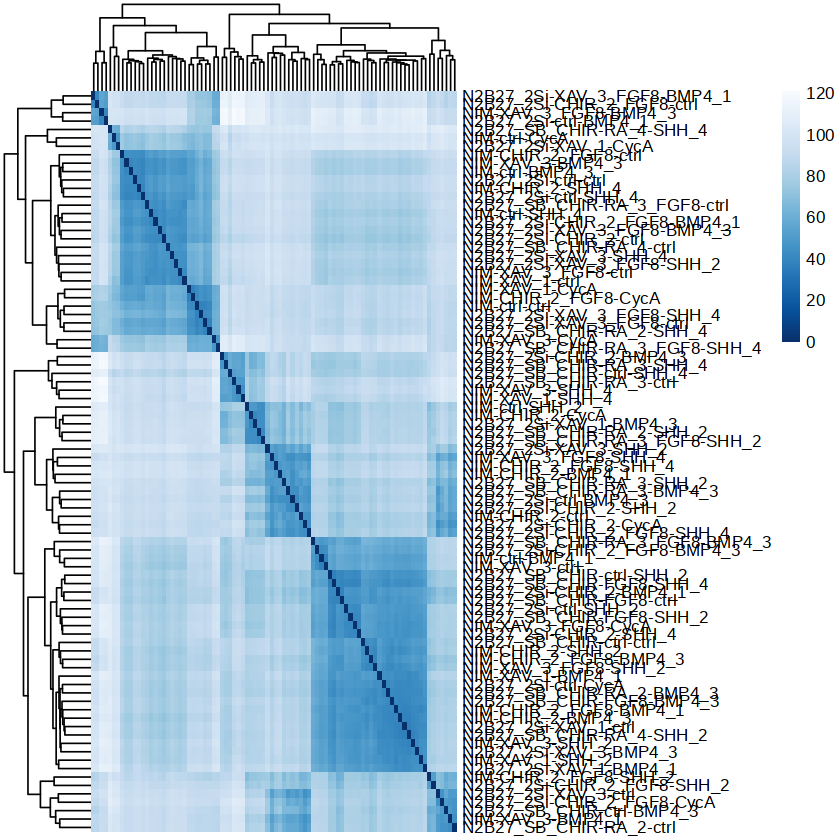

In [84]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(vsd$Basal_media, vsd$AP_axis, vsd$DV_axis, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

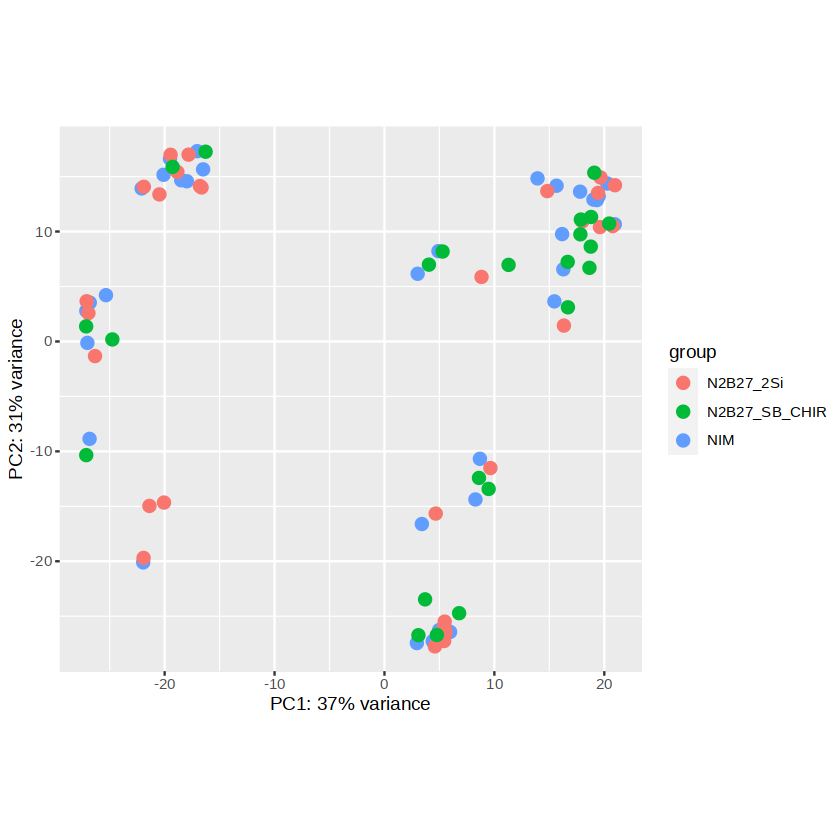

In [85]:
plotPCA(vsd, intgroup=c("Basal_media"))

In [ ]:
pca_df <- vsd
ntop <- 1000
plotPCA(pca_df, intgroup=c("condition"),ntop=ntop)


pcaData <- plotPCA(pca_df, intgroup=c("condition", "Sex"), returnData=TRUE,ntop=ntop)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=condition, shape=Sex)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

pcaData <- plotPCA(pca_df, intgroup=c("condition", "Age_C"), returnData=TRUE,ntop=ntop)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=condition, shape=Age_C)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

pcaData <- plotPCA(pca_df, intgroup=c("condition", "PMI_C"), returnData=TRUE,ntop=ntop)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=condition, shape=PMI_C)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

pcaData <- plotPCA(pca_df, intgroup=c("condition", "skew_C"), returnData=TRUE,ntop=ntop)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=condition, shape=skew_C)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() 

In [ ]:
meta <- read.table("~/jjans/analysis/iNeuron_morphogens/pilot/